In [15]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

#import F
from torch.nn import functional as F

In [16]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [17]:
from torchvision import datasets

In [18]:
# transforms, convert to greyscale, convert to tensor, normalize and move to cuda
trainTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

validTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

In [19]:
trainFolder = 'train'
trainDataset = datasets.ImageFolder(trainFolder, transform=trainTransforms)

# Select 1000 images only to train
#trainDataset = torch.utils.data.Subset(trainDataset, np.random.choice(len(trainDataset), 1000, replace=False))

validFolder = 'val'
validDataset = datasets.ImageFolder(validFolder, transform=validTransforms)

# Select 100 images only to validate
#validDataset = torch.utils.data.Subset(validDataset, np.random.choice(len(validDataset), 100, replace=False))

In [20]:
print('Train dataset:', len(trainDataset))
print('Valid dataset:', len(validDataset))

Train dataset: 5153
Valid dataset: 500


In [21]:
#Import DataLoader
from torch.utils.data import DataLoader
batchSize = 32
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=True)   

In [22]:
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten()
        )
        
        # mean and variance for the latent space
        self.fc1 = nn.Linear(256*16*16, 256)
        self.fc2 = nn.Linear(256*16*16, 256)
        
        
        #define the decoder
        self.decoder = nn.Sequential(
            nn.Linear(256, 512*8*8),
            nn.Unflatten(1, (512, 8, 8)),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    # define the forward pass
    def forward(self, x):
        x = self.encoder(x.view(-1, 3, 512, 512))
        mu, logvar = self.fc1(x), self.fc2(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder(z.view(-1, 256))
        return z, mu, logvar
        
            

In [23]:
# print summary for input of size 512x512 and 3 channels
model = VariationalAutoEncoder().to(device)
from torchsummary import summary
summary(model, (3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 65536]               --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        448
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─ReLU: 2-5                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-8                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-9                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 65536]               --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        448
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─ReLU: 2-5                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-8                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-9                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
|  

In [24]:
# training batch
def trainBatch(data, model, optimiser, loss_function):
    model.train()
    data = data.to(device)
    optimiser.zero_grad()
    
    reconstructedBatch, mu, logvar = model(data)
    
    # calculate loss
    loss,mse,KLdivergence = loss_function(reconstructedBatch, data, mu, logvar)
    loss.backward()
    optimiser.step()
    
    return loss, mse, KLdivergence, logvar.mean(), mu.mean()

In [25]:
# validation batch
@torch.no_grad()
def validateBatch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    
    reconstructedBatch, mu, logvar = model(data)
    
    # calculate loss
    loss,mse,KLdivergence = loss_function(reconstructedBatch, data, mu, logvar)
    
    return loss, mse, KLdivergence, logvar.mean(), mu.mean()

In [26]:
# def loss_function
def loss_function(reconstructedBatch, data, mu, logvar):
    reconstruction = F.mse_loss(reconstructedBatch, data.view(-1, 3, 512, 512), reduction='sum')
    KLdivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reconstruction + KLdivergence, reconstruction, KLdivergence

In [27]:
# Initialize model
model = VariationalAutoEncoder().to(device)

# Initialize optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=0.005)

EPOCH: 0.938  val_loss: 2069562.250  val_kld: 22971.301  val_recon: 2046591.000  val_log_var: -5.626  val_mean: 0.002  (47.55s - 206.04s remaining)))ng)ining)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1.000  train_recon: 1564259.097  val_kld: 22739.857  val_recon: 2069323.950  val_log_var: -5.587  train_mean: -0.007  train_loss: 1589590.519  train_log_var: -5.957  val_loss: 2092063.800  val_mean: -0.004  train_kld: 25331.424  (47.63s - 190.53s remaining)


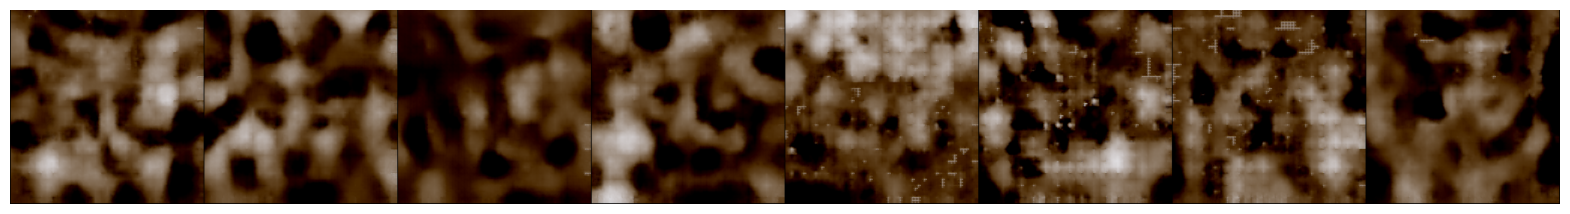

EPOCH: 1.938  val_loss: 1566746.875  val_kld: 25122.846  val_recon: 1541624.000  val_log_var: -6.001  val_mean: -0.011  (95.29s - 150.62s remaining)ining)ing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 2.000  train_recon: 1558283.250  val_kld: 24196.201  val_recon: 1558426.750  val_log_var: -5.901  train_mean: -0.008  train_loss: 1583841.503  train_log_var: -5.982  val_loss: 1582622.953  val_mean: -0.004  train_kld: 25558.254  (95.37s - 143.06s remaining)


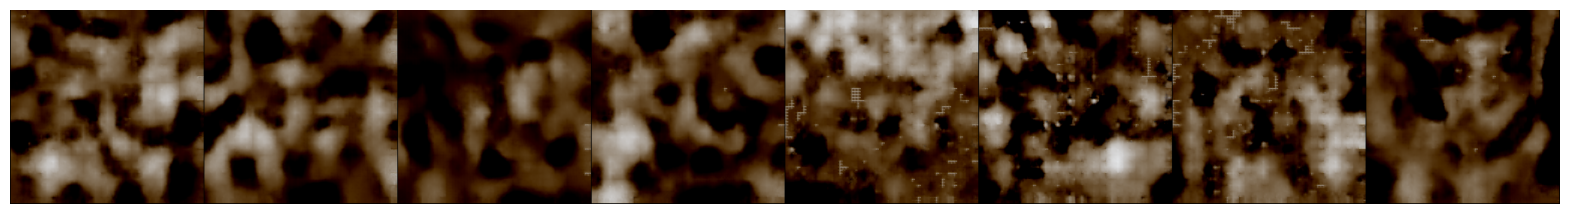

EPOCH: 2.938  val_loss: 1651833.000  val_kld: 26200.488  val_recon: 1625632.500  val_log_var: -6.178  val_mean: 0.005  (141.40s - 99.28s remaining)g)g)aining))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 3.000  train_recon: 1500956.774  val_kld: 25459.007  val_recon: 1569905.520  val_log_var: -6.138  train_mean: -0.006  train_loss: 1526053.805  train_log_var: -6.017  val_loss: 1595364.520  val_mean: -0.002  train_kld: 25097.035  (141.48s - 94.32s remaining)


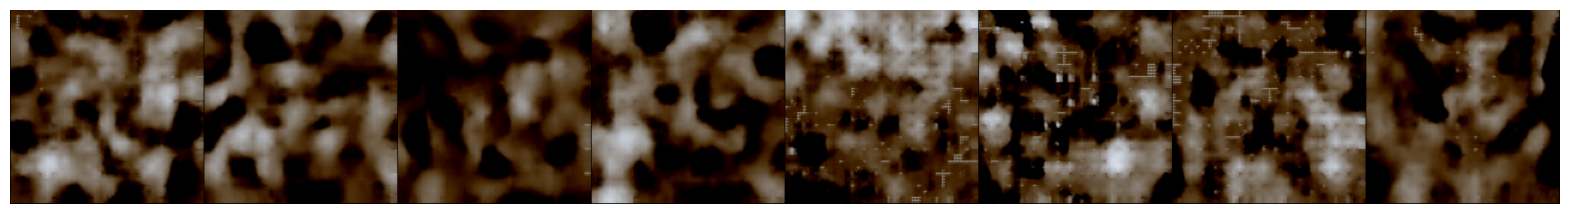

EPOCH: 3.938  val_loss: 1577435.375  val_kld: 26833.967  val_recon: 1550601.375  val_log_var: -6.261  val_mean: -0.011  (189.53s - 51.14s remaining))ng)ning))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 4.000  train_recon: 1479401.950  val_kld: 25057.246  val_recon: 1547528.805  val_log_var: -6.074  train_mean: -0.006  train_loss: 1504355.221  train_log_var: -5.935  val_loss: 1572586.047  val_mean: -0.017  train_kld: 24953.272  (189.64s - 47.41s remaining)


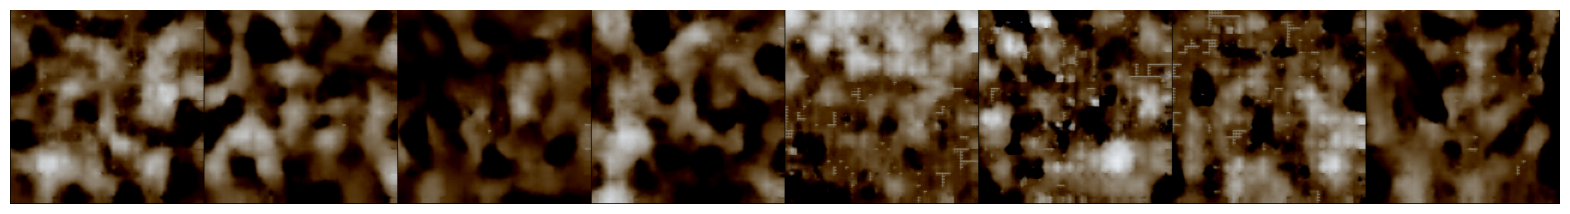

EPOCH: 4.938  val_loss: 1494064.250  val_kld: 25525.273  val_recon: 1468539.000  val_log_var: -6.031  val_mean: 0.005  (237.15s - 3.00s remaining)))ing)ning))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 5.000  train_recon: 1456231.301  val_kld: 24620.038  val_recon: 1530836.539  val_log_var: -5.999  train_mean: -0.006  train_loss: 1481234.135  train_log_var: -5.943  val_loss: 1555456.570  val_mean: -0.004  train_kld: 25002.833  (237.24s - 0.00s remaining)


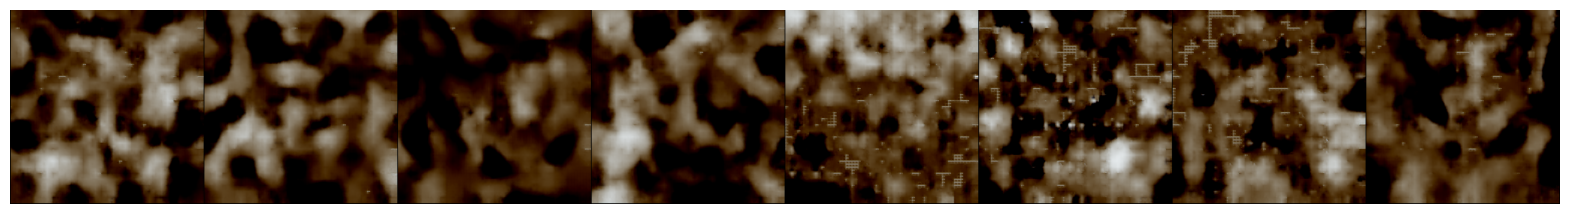

In [36]:
#import report
from torch_snippets import Report

#import make_grid
from torchvision.utils import make_grid

# import show
from torch_snippets import show
n_epochs = 5
log = Report(n_epochs)
z = torch.randn(8, 256).to(device)
for epoch in range(n_epochs):
    N = len(trainLoader)
    for batchIndex , (image, label) in enumerate(trainLoader):
        loss, recon, KL, log_var, mean = trainBatch(image, model, optimiser, loss_function)
        
        pos = epoch + (batchIndex + 1)/N
        log.record(pos, train_loss = loss, train_kld=KL, train_recon=recon,train_log_var=log_var, train_mean=mean, end='\r')
    
    N = len(validLoader)
    for batchIndex, (image, label) in enumerate(validLoader):
        loss, recon, KL, log_var, mean = validateBatch(image, model, loss_function)
        
        pos = epoch + (batchIndex + 1)/N
        log.record(pos, val_loss = loss, val_kld=KL, val_recon=recon,val_log_var=log_var, val_mean=mean, end='\r') 
        
    log.report_avgs(epoch+1)
    
    # print 23 new generated images in 5x5 grid
    with torch.no_grad():
        # set grid size
        sample = model.decoder(z).to(device)
        images = make_grid(sample.view(8,3,512,512)).permute(1,2,0)
        show(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


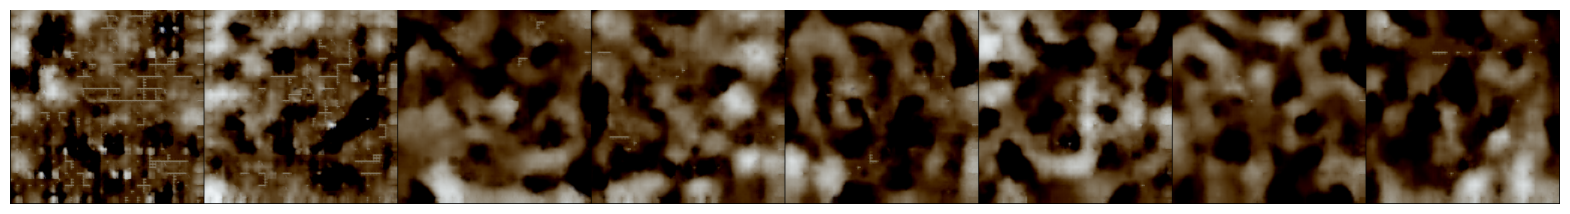

In [37]:
with torch.no_grad():
 # set grid size
   # generate random latent vector from N(0,1)
    z = torch.randn(8, 256).to(device)
    sample = model.decoder(z).to(device)
    images = make_grid(sample.view(8,3,512,512)).permute(1,2,0)
    show(images)

100%|██████████| 106/106 [00:00<00:00, 15915.38it/s]

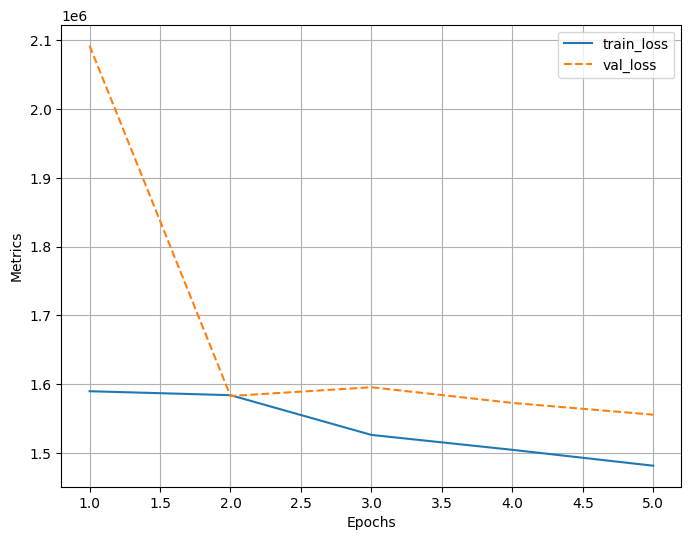

In [38]:
log.plot_epochs(['train_loss', 'val_loss'])